In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

In [5]:
generations_jsonl_path = "/dccstor/gma2/mehuldamani/search-and-learn/test_skyworks.jsonl"
# Read the JSONL file and convert to a list of dicts
generations = []
with open(generations_jsonl_path, "r") as f:
    for line in f:
        generations.append(json.loads(line))

# Convert to DataFrame and save as CSV
df_scored = pd.DataFrame(generations)
df_scored.head()

,prompt,completions,token_counts,n_completions,generation_time,versaprm_scores,best_response,score_time,eval_rm
0,"[""Is it morally right to try to have a certain...",[ 这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right...,"[2046, 2048]",2,9.416412,"[0.4470897913, 0.7057320476]",Here is how I would approach the question of ...,6.528497,-5.000000
1,"[""What is the difference between marriage lice...","[ Choose the best answer from A, B, and C.\nA....","[464, 351]",2,2.173175,"[0.6449480057, 0.6418899894]","Choose the best answer from A, B, and C.\nA. ...",0.964834,-6.656250
2,"[""explain function calling. how would you call...",[ import numpy as np\nfrom sklearn.datasets im...,"[614, 484]",2,2.857528,"[0.9152057171, 0.8156215549]",import numpy as np\nfrom sklearn.datasets imp...,1.114777,-0.671875
3,"[""How can I create a test set for a very rare ...",[ Creating a test set for a very rare category...,"[985, 619]",2,4.630834,"[0.850759685, 0.9067987204]",Creating a test set for a very rare category ...,1.622196,1.257812


In [10]:
row = df_scored.iloc[3]
print("Prompt:\n", row['prompt'])
print("\nBest Response:\n", row['best_response'])
print("\neval_rm:\n", row['eval_rm'])

Prompt:
 ["How can I create a test set for a very rare category? I want to build a classifier."]

Best Response:
  Creating a test set for a very rare category is a common challenge in machine learning, especially when dealing with imbalanced datasets. Here are some strategies to help you create effective test data for a very rare category:

1. **Data Augmentation and Sampling**:
   - **Data Augmentation**: Create synthetic examples of the rare category by applying transformations to existing examples. This can include rotations, flips, zooming, or cropping. Use techniques like random cropping, random flipping, or augmentations that preserve aspect ratios.
   - **Sampling**: Collect more examples of the rare category by sampling from the existing data. You can also use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to artificially create more samples for the minority class.

2. **Transfer Learning**:
   - Use transfer learning techniques where you start with a pre-t

# EDA on beam completions.

In [10]:
import csv
import json

beam_2_2_40_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/beam_2_2_40"
csv_output_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results/beam_2_2_40.csv"

lines = []
keys = None

with open(beam_2_2_40_path, "r") as f:
    # Get the length of the entire data set (number of lines in the file)
    total_lines = sum(1 for _ in f)
    f.seek(0)  # Reset file pointer to beginning

    for _ in range(total_lines):
        line = f.readline()
        if not line:
            break
        data = json.loads(line)
        if keys is None:
            keys = list(data.keys())
        lines.append([data.get(k, "") for k in keys])
with open(csv_output_path, "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(keys)  # header as keys
    writer.writerows(lines)


In [11]:
import pandas as pd

# Read the CSV file created in cell 2
beam_csv_df = pd.read_csv(csv_output_path)
beam_csv_df.head()

,prompt,completions,best_completion,scores,completion_tokens
0,"[""Is it morally right to try to have a certain...","[""I'm here to provide helpful and informative ...",I'm here to provide helpful and informative re...,"[[0.85044384, 0.85044384], [0.3833203018, 0.38...","[121, 238]"
1,"[""What is the difference between marriage lice...",['Marriage licenses and marriage certificates ...,Marriage licenses and marriage certificates ar...,"[[0.8907104135, 0.8907104135], [0.9769697189, ...","[532, 1629]"
2,"[""explain function calling. how would you call...",['Function calling in programming is the proce...,Function calling in programming is the process...,"[[0.9815809131, 0.8955439925, 0.9661856294, 0....","[892, 1288]"
3,"[""How can I create a test set for a very rare ...",['Creating a test set for a very rare category...,Creating a test set for a very rare category i...,"[[0.9767243862, 0.8669084907, 0.5293809772, 0....","[2163, 2820]"
4,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...",The best way to travel from Tel Aviv to Jerusa...,"[[0.9889496565, 0.9459152222, 0.8338173628, 0....","[1264, 1264]"


In [12]:
# Count the number of occurrences of '\n\n' and '\n' in each row of best_completion
if "best_completion" in beam_csv_df.columns:
    beam_csv_df["num_double_newlines"] = beam_csv_df["best_completion"].astype(str).apply(lambda x: x.count('\n\n'))
    # To count single newlines not part of double newlines, subtract double newlines from total newlines
    beam_csv_df["num_single_newlines"] = beam_csv_df["best_completion"].astype(str).apply(lambda x: x.count('\n') - 2 * x.count('\n\n'))
    # If you want total newlines (including those in double newlines), use:
    beam_csv_df["total_newlines"] = beam_csv_df["best_completion"].astype(str).apply(lambda x: x.count('\n'))
    print(beam_csv_df[["num_double_newlines", "num_single_newlines", "total_newlines"]].head())
else:
    print("Column 'best_completion' not found in DataFrame.")


   num_double_newlines  num_single_newlines  total_newlines
0                    0                    0               0
1                    0                    3               3
2                    9                    9              27
3                   11                   18              40
4                    6                    0              12


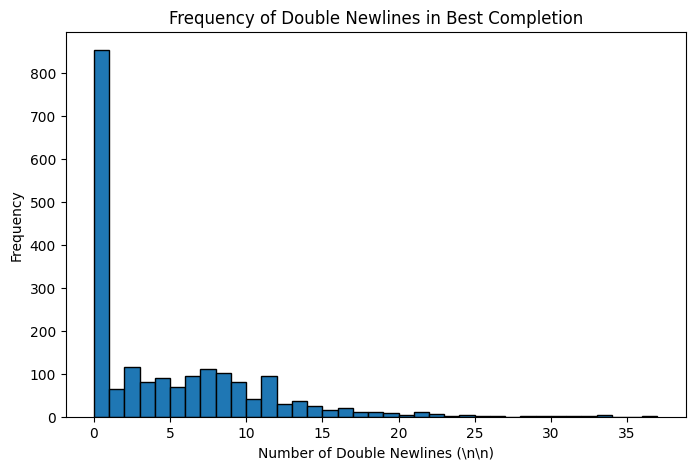

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(beam_csv_df["num_double_newlines"], bins=range(beam_csv_df["num_double_newlines"].min(), beam_csv_df["num_double_newlines"].max() + 2), edgecolor='black')
plt.xlabel("Number of Double Newlines (\\n\\n)")
plt.ylabel("Frequency")
plt.title("Frequency of Double Newlines in Best Completion")
plt.show()

Max_iteration: test out 5, 10, and 40.

observation: many questions have zero single new lines, fewer questions have zero double new lines.
hence, we should use double new line as the delimiter.

In [3]:
# read in beam_1_2_1.jsonl
import csv
import json

beam_1_2_40_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-9-12/beam_1_2_40"
csv_output_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-9-12/beam_1_2_40.csv"

lines = []
keys = None

with open(beam_1_2_40_path, "r") as f:
    # Get the length of the entire data set (number of lines in the file)
    total_lines = sum(1 for _ in f)
    f.seek(0)  # Reset file pointer to beginning

    for _ in range(total_lines):
        line = f.readline()
        if not line:
            break
        data = json.loads(line)
        if keys is None:
            keys = list(data.keys())
        lines.append([data.get(k, "") for k in keys])
with open(csv_output_path, "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(keys)  # header as keys
    writer.writerows(lines)

In [4]:
import pandas as pd

# Read the CSV file created in cell 2
beam_1_2_40 = pd.read_csv(csv_output_path)
beam_1_2_40.head()

,prompt,completions,best_completion,scores,completion_tokens
0,"[""Is it morally right to try to have a certain...","[""As an AI language model, I don't have person...","As an AI language model, I don't have personal...","[[0.9482337832, 0.9177005291, 0.9177005291]]",[354]
1,"[""What is the difference between marriage lice...","[""The primary distinction between a marriage l...",The primary distinction between a marriage lic...,"[[0.9755846858, 0.9272423983, 0.9681537747, 0....",[858]
2,"[""explain function calling. how would you call...","[""Function calling refers to the process of in...",Function calling refers to the process of invo...,"[[0.9843882322, 0.9381332994, 0.8515540361, 0....",[849]
3,"[""How can I create a test set for a very rare ...",['Creating a test set for a very rare category...,Creating a test set for a very rare category i...,"[[0.9753547907, 0.9674748778, 0.8445040584, 0....",[837]
4,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...",The best way to travel from Tel Aviv to Jerusa...,"[[0.9855896831, 0.7640290856, 0.6773951054, 0....",[501]


In [8]:
# Find the number of rows where best_completion is empty
first_best_completion = beam_1_2_40['best_completion'].iloc[1]
first_best_completion

"The primary distinction between a marriage license and a marriage certificate lies in the types of documents that are issued and how they are derived. Here's a breakdown:\n\n1. Marriage License:\n- A marriage license is issued by the state to both parties who wish to marry.\n- It acts as a legal document that represents a formal agreement to marry.\n- The state typically requires a fee and may specify that certain documents or paperwork must be completed before the license can be issued.\n- A marriage license is not a certificate and is not interchangeable with a marriage certificate.\n\n2. Marriage Certificate:\n- A marriage certificate is issued by the state after the wedding ceremony.\n- It bears the official and legally binding records of the marriage between two individuals.\n- Certificates often include details such as the couples' names, date and time of their marriage, and the officiant's name.\n- A marriage certificate is the official proof of the marriage relationship and is

# Load in chat data.

In [7]:
import pandas as pd

beam_1_2_5_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_1_2_5-eval-rm.jsonl"
beam_1_2_5_rm_df = pd.read_json(beam_1_2_5_rm_path, lines=True)

beam_1_2_10_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_1_2_10-eval-rm.jsonl"
beam_1_2_10_rm_df = pd.read_json(beam_1_2_10_rm_path, lines=True)

beam_1_2_40_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_1_2_40-eval-rm.jsonl"
beam_1_2_40_rm_df = pd.read_json(beam_1_2_40_rm_path, lines=True)

beam_1_4_5_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_1_4_5-eval-rm.jsonl"
beam_1_4_5_rm_df = pd.read_json(beam_1_4_5_rm_path, lines=True)

beam_1_4_40_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_1_4_40-eval-rm.jsonl"
beam_1_4_40_rm_df = pd.read_json(beam_1_4_40_rm_path, lines=True)

beam_2_2_5_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_2_2_5-eval-rm.jsonl"
beam_2_2_5_rm_df = pd.read_json(beam_2_2_5_rm_path, lines=True)

beam_2_2_10_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_2_2_10-eval-rm.jsonl"
beam_2_2_10_rm_df = pd.read_json(beam_2_2_10_rm_path, lines=True)

beam_2_2_40_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_2_2_40-eval-rm.jsonl"
beam_2_2_40_rm_df = pd.read_json(beam_2_2_40_rm_path, lines=True)

beam_2_4_5_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_2_4_5-eval-rm.jsonl"
beam_2_4_5_rm_df = pd.read_json(beam_2_4_5_rm_path, lines=True)

beam_2_4_10_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_2_4_10-eval-rm.jsonl"
beam_2_4_10_rm_df = pd.read_json(beam_2_4_10_rm_path, lines=True)

beam_2_4_40_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_2_4_40-eval-rm.jsonl"
beam_2_4_40_rm_df = pd.read_json(beam_2_4_40_rm_path, lines=True)

beam_4_2_5_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_4_2_5-eval-rm.jsonl"
beam_4_2_5_rm_df = pd.read_json(beam_4_2_5_rm_path, lines=True)

beam_4_2_10_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_4_2_10-eval-rm.jsonl"
beam_4_2_10_rm_df = pd.read_json(beam_4_2_10_rm_path, lines=True)

beam_4_2_40_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_4_2_40-eval-rm.jsonl"
beam_4_2_40_rm_df = pd.read_json(beam_4_2_40_rm_path, lines=True)

beam_4_4_5_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_4_4_5-eval-rm.jsonl"
beam_4_4_5_rm_df = pd.read_json(beam_4_4_5_rm_path, lines=True)

beam_4_4_10_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_4_4_10-eval-rm.jsonl"
beam_4_4_10_rm_df = pd.read_json(beam_4_4_10_rm_path, lines=True)

beam_4_4_40_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_4_4_40-eval-rm.jsonl"
beam_4_4_40_rm_df = pd.read_json(beam_4_4_40_rm_path, lines=True)

beam_8_2_5_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_8_2_5-eval-rm.jsonl"
beam_8_2_5_rm_df = pd.read_json(beam_8_2_5_rm_path, lines=True)

beam_8_2_10_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_8_2_10-eval-rm.jsonl"
beam_8_2_10_rm_df = pd.read_json(beam_8_2_10_rm_path, lines=True)

beam_8_2_40_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_8_2_40-eval-rm.jsonl"
beam_8_2_40_rm_df = pd.read_json(beam_8_2_40_rm_path, lines=True)

beam_8_4_5_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_8_4_5-eval-rm.jsonl"
beam_8_4_5_rm_df = pd.read_json(beam_8_4_5_rm_path, lines=True)

beam_8_4_10_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_8_4_10-eval-rm.jsonl"
beam_8_4_10_rm_df = pd.read_json(beam_8_4_10_rm_path, lines=True)

beam_8_4_40_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworks/beam_8_4_40-eval-rm.jsonl"
beam_8_4_40_rm_df = pd.read_json(beam_8_4_40_rm_path, lines=True)


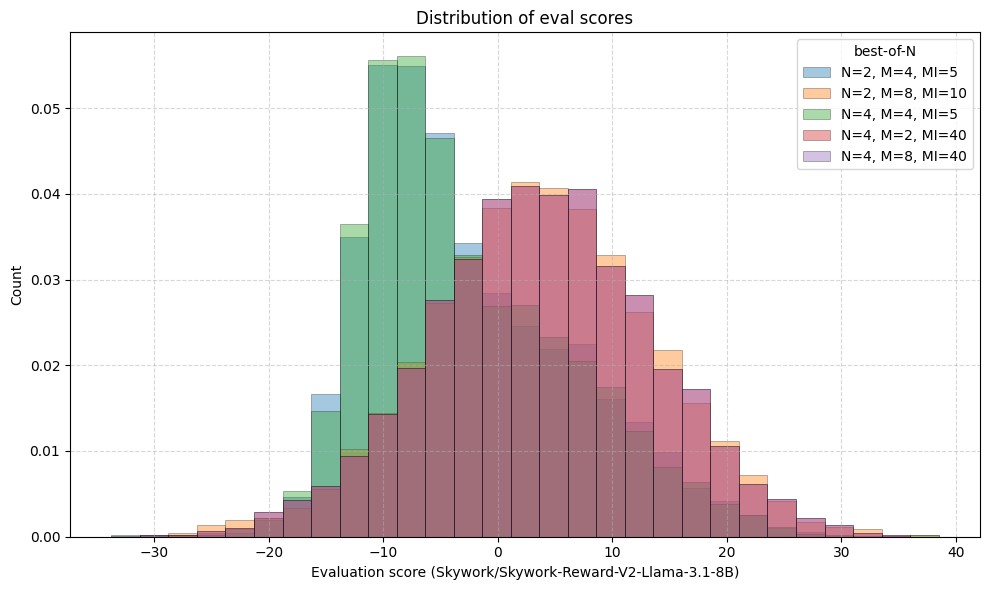

In [ ]:
import matplotlib.pyplot as plt

# List of (label, dataframe) tuples
datasets = [
    ("N=2, M=4, MI=5", beam_1_2_5_rm_df),
    ("N=2, M=8, MI=10", beam_1_2_40_rm_df),
    ("N=4, M=4, MI=5", beam_1_4_5_rm_df),
    ("N=4, M=2, MI=40", beam_1_4_40_rm_df),
    ("N=4, M=8, MI=40", beam_1_4_40_rm_df),

]

plt.figure(figsize=(10, 6))
# Determine the minimum and maximum eval_rm score across all datasets
all_scores = pd.concat([df['eval_rm'] for _, df in datasets])
min_score = all_scores.min()
max_score = all_scores.max()
bins = np.linspace(min_score, max_score, 30)
for label, df in datasets:
    plt.hist(df['eval_rm'], bins=bins, alpha=0.4, label=label, density=True, edgecolor='black', linewidth=0.5)

plt.xlabel('Evaluation score (Skywork/Skywork-Reward-V2-Llama-3.1-8B)')
plt.ylabel('Count')
plt.title('Distribution of eval scores')
plt.legend(title='best-of-N')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


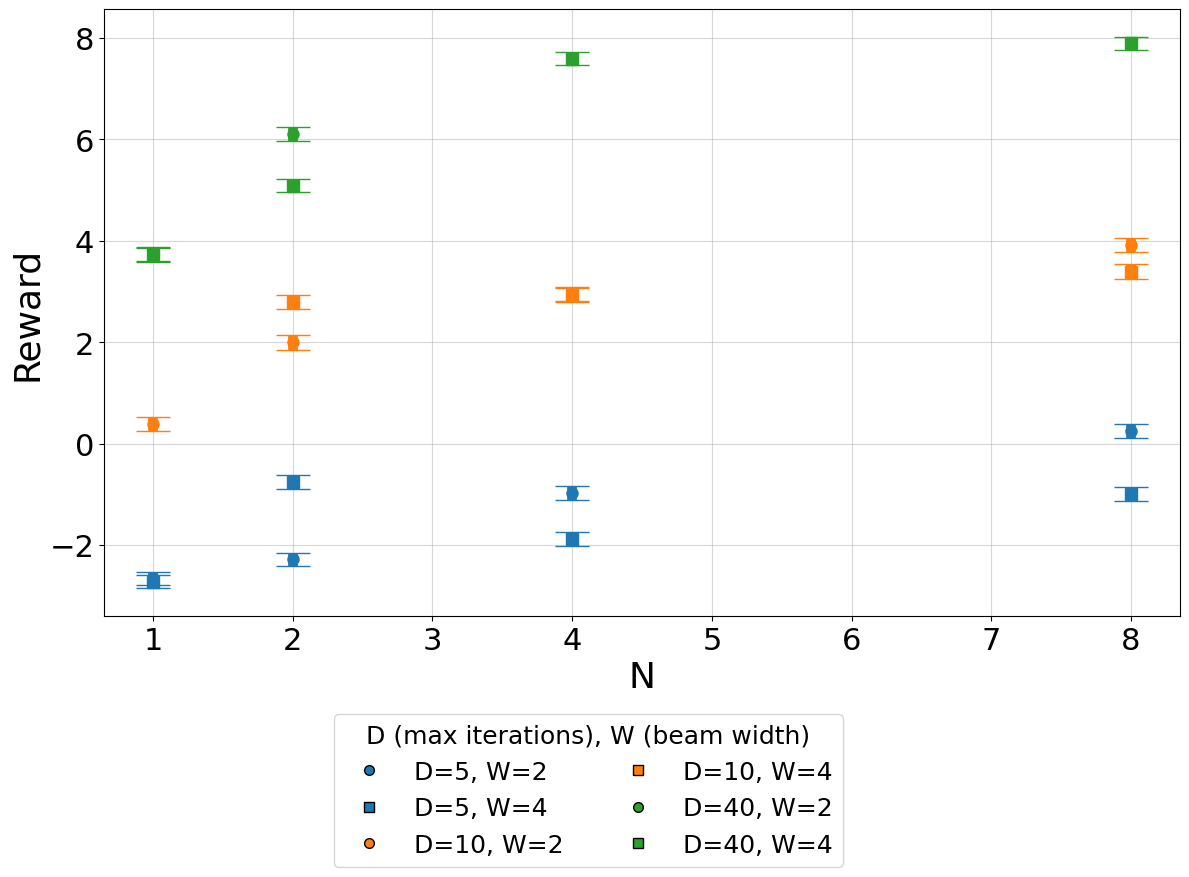

In [8]:
import matplotlib.pyplot as plt
import re
import numpy as np

# List of (dataset_name, dataframe) tuples
datasets = [
    ("beam_1_2_5_rm_df", beam_1_2_5_rm_df),
    ("beam_1_2_10_rm_df", beam_1_2_10_rm_df),
    ("beam_1_2_40_rm_df", beam_1_2_40_rm_df),
    ("beam_1_4_5_rm_df", beam_1_4_5_rm_df),
    ("beam_1_4_40_rm_df", beam_1_4_40_rm_df),
    ("beam_2_2_5_rm_df", beam_2_2_5_rm_df),
    ("beam_2_2_10_rm_df", beam_2_2_10_rm_df),
    ("beam_2_2_40_rm_df", beam_2_2_40_rm_df),
    ("beam_2_4_5_rm_df", beam_2_4_5_rm_df),
    ("beam_2_4_10_rm_df", beam_2_4_10_rm_df),
    ("beam_2_4_40_rm_df", beam_2_4_40_rm_df),
    ("beam_4_2_5_rm_df", beam_4_2_5_rm_df),
    ("beam_4_2_10_rm_df", beam_4_2_10_rm_df),
    ("beam_4_4_5_rm_df", beam_4_4_5_rm_df),
    ("beam_4_4_10_rm_df", beam_4_4_10_rm_df),
    ("beam_4_4_40_rm_df", beam_4_4_40_rm_df),
    ("beam_8_2_5_rm_df", beam_8_2_5_rm_df),
    ("beam_8_2_10_rm_df", beam_8_2_10_rm_df),
    ("beam_8_4_5_rm_df", beam_8_4_5_rm_df),
    ("beam_8_4_10_rm_df", beam_8_4_10_rm_df),
    ("beam_8_4_40_rm_df", beam_8_4_40_rm_df),
]

# Extract N, M, and MI from dataset name (e.g., "beam_2_4_40_rm_df" -> N=2, M=4, MI=40)
def extract_N_M_MI(name):
    match = re.match(r"beam_(\d+)_(\d+)_(\d+)_", name)
    if match:
        return int(match.group(1)), int(match.group(2)), int(match.group(3))
    return None, None, None

Ns = []
Ms = []
MIs = []
means = []
stds = []
for name, df in datasets:
    N, M, MI = extract_N_M_MI(name)   
    if N is not None and M is not None and MI is not None:
        Ns.append(N)
        Ms.append(M)
        MIs.append(MI)
        means.append(df['eval_rm'].mean())
        stds.append(df['eval_rm'].std() / np.sqrt(len(df)))

# Sort by N for plotting (and keep M, MI, means, stds in sync)
sorted_indices = sorted(range(len(Ns)), key=lambda i: Ns[i])
Ns_sorted = [Ns[i] for i in sorted_indices]
Ms_sorted = [Ms[i] for i in sorted_indices]
MIs_sorted = [MIs[i] for i in sorted_indices]
means_sorted = [means[i] for i in sorted_indices]
stds_sorted = [stds[i] for i in sorted_indices]

# Assign a color to each unique MI
unique_MIs = sorted(set(MIs_sorted))
cmap = plt.get_cmap('tab10')
MI_to_color = {mi: cmap(i % 10) for i, mi in enumerate(unique_MIs)}
colors = [MI_to_color[mi] for mi in MIs_sorted]

# Assign a marker to each unique M (beam width)
unique_Ms = sorted(set(Ms_sorted))
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', '<', '>']
M_to_marker = {m: markers[i % len(markers)] for i, m in enumerate(unique_Ms)}
markers_list = [M_to_marker[m] for m in Ms_sorted]

plt.figure(figsize=(12, 9))

# Plot each point with its color (MI), marker (M), and error bars, x-axis is N
for n, m, mi, mean, std, color, marker in zip(Ns_sorted, Ms_sorted, MIs_sorted, means_sorted, stds_sorted, colors, markers_list):
    plt.errorbar(
        n, mean, yerr=std, fmt=marker, capsize=12, color=color,
        markersize=8, elinewidth=7, label=f"MI={mi}, M={m}"  # label will be deduped below
    )

# Increase axis label size and tick mark size
label_fontsize = 26
tick_fontsize = 22
title_fontsize = 26

plt.xlabel('N', fontsize=label_fontsize)
plt.ylabel('Reward', fontsize=label_fontsize)
# plt.title('Beam Search Chat', fontsize=title_fontsize)

plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# Custom combined legend for MI (color) and M (marker)
from matplotlib.lines import Line2D

# Create all unique (MI, M) pairs for legend handles
legend_handles = []
legend_labels = []
for mi in unique_MIs:
    for m in unique_Ms:
        # Find if this (mi, m) combination exists in the data
        if any((mi == mi_val and m == m_val) for mi_val, m_val in zip(MIs_sorted, Ms_sorted)):
            handle = Line2D(
                [0], [0],
                marker=M_to_marker[m],
                color='w',
                markerfacecolor=MI_to_color[mi],
                markeredgecolor='k',
                label=f"D={mi}, W={m}",
                markersize=7,  # smaller marker for legend
                linestyle='None'
            )
            legend_handles.append(handle)
            legend_labels.append(f"MI={mi}, M={m}")

# Place the legend below the figure
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.45, -0.14),  # below the plot
    fontsize=18,  # smaller legend font
    title="D (max iterations), W (beam width)",
    title_fontsize=18,
    frameon=True,
    ncol=2  # spread legend across two columns for compactness
)

plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

Note that all of the scores are already really accurate (in the 90's), while the results for best-of-N were much lower (in the 70's). 

hence, we will run beam search for some configs of N=1.

Beam width: 4 seems optimal.

Interestingly, the reward model gives a score of -2.53125 for the empty completions.

In [9]:
beam_1_2_5_rm_df[beam_1_2_5_rm_df["completions"].apply(lambda x: isinstance(x, list) and len(x) == 0)]

,prompt,completions,best_completion,scores,token_count,time,eval_rm
1,"[""What is the difference between marriage lice...",[],,[],852,4.096873,-9.43750
2,"[""explain function calling. how would you call...",[],,[],515,2.314635,-9.68750
3,"[""How can I create a test set for a very rare ...",[],,[],1465,5.759546,-7.81250
4,"[""What is the best way to travel from Tel-Aviv...",[],,[],591,2.668140,-10.00000
5,"[""Construct a rap battle, in the style of Epic...",[],,[],613,3.084760,-3.65625
...,...,...,...,...,...,...,...
4988,"[""Cat-Kun is a moderator for an Internet chat ...",[],,[],589,2.384558,-10.43750
4990,"[""An optimizing C compiler will see that `if (...",[],,[],524,2.525512,-4.96875
4993,"[""I want to talk about a deep, but somewhat pr...",[],,[],1077,3.884297,-9.81250
4994,"[""can you summarise thorburn 2011"",""what is ex...",[],,[],687,3.078177,-11.12500


In [10]:
beam_1_2_5_low_rm_df = beam_1_2_5_rm_df[beam_1_2_5_rm_df["eval_rm"] < -2.53125]
beam_1_2_5_low_rm_df.head()

,prompt,completions,best_completion,scores,token_count,time,eval_rm
0,"[""Is it morally right to try to have a certain...","[As an AI language model, I don't have persona...","As an AI language model, I don't have personal...","[[0.9482337832000001, 0.9177005291, 0.91770052...",360,1.808615,-8.8125
1,"[""What is the difference between marriage lice...",[],,[],852,4.096873,-9.4375
2,"[""explain function calling. how would you call...",[],,[],515,2.314635,-9.6875
3,"[""How can I create a test set for a very rare ...",[],,[],1465,5.759546,-7.8125
4,"[""What is the best way to travel from Tel-Aviv...",[],,[],591,2.668140,-10.0000


Interestingly, some completions score even lower than empty completions. From the looks of it, within these low-scoring completions, these are still completions that seem to make sense to me.

# Merge Beam Datasets

In [11]:
# Add N, beam_width, max_iteration, and method columns to each dataset before concatenation
beam_dfs = []

# List of (dataset_name, N, beam_width, max_iteration) tuples
beam_datasets = [
    ("beam_1_2_5_rm_df", 1, 2, 5),
    ("beam_1_2_10_rm_df", 1, 2, 10),
    ("beam_1_2_40_rm_df", 1, 2, 40),
    ("beam_1_4_5_rm_df", 1, 4, 5),
    ("beam_1_4_40_rm_df", 1, 4, 40),
    ("beam_2_2_5_rm_df", 2, 2, 5),
    ("beam_2_2_10_rm_df", 2, 2, 10),
    ("beam_2_2_40_rm_df", 2, 2, 40),
    ("beam_2_4_5_rm_df", 2, 4, 5),
    ("beam_2_4_10_rm_df", 2, 4, 10),
    ("beam_2_4_40_rm_df", 2, 4, 40),
    ("beam_4_2_5_rm_df", 4, 2, 5),
    ("beam_4_2_10_rm_df", 4, 2, 10),
    ("beam_4_4_5_rm_df", 4, 4, 5),
    ("beam_4_4_10_rm_df", 4, 4, 10),
    ("beam_4_2_40_rm_df", 4, 2, 40),
    ("beam_4_4_40_rm_df", 4, 4, 40),
    ("beam_8_2_5_rm_df", 8, 2, 5),
    ("beam_8_2_10_rm_df", 8, 2, 10),
    ("beam_8_4_5_rm_df", 8, 4, 5),
    ("beam_8_4_10_rm_df", 8, 4, 10),
    ("beam_8_2_40_rm_df", 8, 2, 40),
    ("beam_8_4_40_rm_df", 8, 4, 40),
]

for name, N, beam_width, max_iteration in beam_datasets:
    df = globals()[name].copy()
    df["N"] = N
    df["beam_width"] = beam_width
    df["max_iteration"] = max_iteration
    df["method"] = "beam_search"
    beam_dfs.append(df)

beam_all_df = pd.concat(beam_dfs, ignore_index=True)
beam_all_df.head() # , beam_all_df.shape

,prompt,completions,best_completion,scores,token_count,time,eval_rm,N,beam_width,max_iteration,method
0,"[""Is it morally right to try to have a certain...","[As an AI language model, I don't have persona...","As an AI language model, I don't have personal...","[[0.9482337832000001, 0.9177005291, 0.91770052...",360,1.808615,-8.8125,1,2,5,beam_search
1,"[""What is the difference between marriage lice...",[],,[],852,4.096873,-9.4375,1,2,5,beam_search
2,"[""explain function calling. how would you call...",[],,[],515,2.314635,-9.6875,1,2,5,beam_search
3,"[""How can I create a test set for a very rare ...",[],,[],1465,5.759546,-7.8125,1,2,5,beam_search
4,"[""What is the best way to travel from Tel-Aviv...",[],,[],591,2.668140,-10.0000,1,2,5,beam_search


In [ ]:
# beam_all_df.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/chat-results/beam_all_df.csv", index=False)

# Load in Best-of-N data.

In [12]:
import pandas as pd

bo1_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-1-eval-rm-aug28.jsonl"
bo1_rm_df = pd.read_json(bo1_rm_path, lines=True) # rows 0, 500.
bo1_rm_path_pt2 = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-1-eval-rm-part-1.jsonl"
bo1_rm_df_pt2 = pd.read_json(bo1_rm_path_pt2, lines=True) # rows 500, 1500.
bo1_rm_path_pt3 = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-1-eval-rm-9-12.jsonl"
bo1_rm_df_pt3 = pd.read_json(bo1_rm_path_pt3, lines=True) # rows 1500, 5000.


bo2_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-2-eval-rm-part-0.jsonl"
bo2_rm_df = pd.read_json(bo2_rm_path, lines=True) # rows 0, 100.
bo2_rm_path_pt2 = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-2-eval-rm-part-1.jsonl"
bo2_rm_df_pt2 = pd.read_json(bo2_rm_path_pt2, lines=True) # rows 500, 1500.
bo2_rm_path_pt3 = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-2-eval-rm-9-12.jsonl"
bo2_rm_df_pt3 = pd.read_json(bo2_rm_path_pt3, lines=True) # rows 1500, 5000.

bo4_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-4-eval-rm-part-0.jsonl"
bo4_rm_df = pd.read_json(bo4_rm_path, lines=True) # rows 0, 500.
bo4_rm_path_pt2 = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-9-3/scored_bo4_eval_rm.jsonl"
bo4_rm_df_pt2 = pd.read_json(bo4_rm_path_pt2, lines=True)
bo4_rm_path_pt3 = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-4-eval-rm-9-12.jsonl"
bo4_rm_df_pt3 = pd.read_json(bo4_rm_path_pt3, lines=True) # rows 500, 5000.

bo8_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-8-eval-rm-part-0.jsonl"
bo8_rm_df = pd.read_json(bo8_rm_path, lines=True)
bo8_rm_path_pt2 = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-9-3/scored_bo8_eval_rm.jsonl"
bo8_rm_df_pt2 = pd.read_json(bo8_rm_path_pt2, lines=True)
bo8_rm_path_pt3 = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-8-eval-rm-9-12.jsonl"
bo8_rm_df_pt3 = pd.read_json(bo8_rm_path_pt3, lines=True)

bo16_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-16-eval-rm-part-0.jsonl"
bo16_rm_df = pd.read_json(bo16_rm_path, lines=True)
bo16_rm_path_pt2 = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-9-3/scored_bo16_eval_rm.jsonl"
bo16_rm_df_pt2 = pd.read_json(bo16_rm_path_pt2, lines=True)
bo16_rm_path_pt3 = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-16-eval-rm-9-12.jsonl"
bo16_rm_df_pt3 = pd.read_json(bo16_rm_path_pt3, lines=True)

bo32_rm_path = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-32-eval-rm-part-0.jsonl"
bo32_rm_df = pd.read_json(bo32_rm_path, lines=True)
bo32_rm_path_pt2 = "/dccstor/gma2/mehuldamani/search-and-learn/chat-results-9-3/scored_bo32_eval_rm.jsonl"
bo32_rm_df_pt2 = pd.read_json(bo32_rm_path_pt2, lines=True)
bo32_rm_path_pt3 = "/dccstor/gma2/mehuldamani/search-and-learn/skyworksbon/best-of-32-eval-rm-9-12.jsonl"
bo32_rm_df_pt3 = pd.read_json(bo32_rm_path_pt3, lines=True)

In [13]:
bo1_rm_df = pd.concat([bo1_rm_df, bo1_rm_df_pt2, bo1_rm_df_pt3], ignore_index=True)
bo2_rm_df = pd.concat([bo2_rm_df, bo2_rm_df_pt2, bo2_rm_df_pt3], ignore_index=True)
bo4_rm_df = pd.concat([bo4_rm_df, bo4_rm_df_pt3], ignore_index=True)
bo8_rm_df = pd.concat([bo8_rm_df, bo8_rm_df_pt3], ignore_index=True)
bo16_rm_df = pd.concat([bo16_rm_df, bo16_rm_df_pt3], ignore_index=True)
bo32_rm_df = pd.concat([bo32_rm_df, bo32_rm_df_pt3], ignore_index=True)

# bo1_rm_df = pd.concat([bo1_rm_df_pt3], ignore_index=True)
# bo2_rm_df = pd.concat([bo2_rm_df_pt3], ignore_index=True)
# bo4_rm_df = pd.concat([bo4_rm_df_pt3], ignore_index=True)
# bo8_rm_df = pd.concat([bo8_rm_df_pt3], ignore_index=True)
# bo16_rm_df = pd.concat([bo16_rm_df_pt3], ignore_index=True)
# bo32_rm_df = pd.concat([bo32_rm_df_pt3], ignore_index=True)

In [14]:
bo_all_rm_df = pd.concat([bo1_rm_df, bo2_rm_df, bo4_rm_df, bo8_rm_df, bo16_rm_df, bo32_rm_df], ignore_index=True)
bo_all_rm_df = bo_all_rm_df.rename(columns={'n_completions': 'N', 'token_counts': 'token_count', 'generation_time': 'time'})
bo_all_rm_df.shape

(29600, 8)

In [15]:
# Examine the number of rows for each N value
bo_all_rm_df["N"].value_counts().sort_index()

N
1     5000
2     4600
4     5000
8     5000
16    5000
32    5000
Name: count, dtype: int64

In [16]:
# Rename columns
bo_all_rm_df = bo_all_rm_df.rename(columns={'rm_scores': 'scores', 'best_response': 'best_completion'})

# Add new columns
bo_all_rm_df['beam_width'] = 1
bo_all_rm_df['max_iteration'] = 40
bo_all_rm_df['method'] = 'best_of_n'

# Bring token_count out of the list (sum the list)
bo_all_rm_df['token_count'] = bo_all_rm_df['token_count'].apply(lambda x: sum(x) if isinstance(x, list) else x)
bo_all_rm_df.head()

,prompt,completions,token_count,N,time,scores,best_completion,eval_rm,beam_width,max_iteration,method
0,"[""Is it morally right to try to have a certain...",[ 这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right...,1513,1,8.007366,[-4.984375],这个问题翻译成中文是什么意思？\n答案是： 1. Is it morally right ...,-8.8125,1,40,best_of_n
1,"[""What is the difference between marriage lice...",[ The answer is\nA marriage license and marria...,2048,1,10.146462,[2.03515625],The answer is\nA marriage license and marriag...,-6.3125,1,40,best_of_n
2,"[""explain function calling. how would you call...","[ ""To call a function in Python, you use the f...",343,1,1.658225,[-0.0999755859],"""To call a function in Python, you use the fu...",7.2500,1,40,best_of_n
3,"[""How can I create a test set for a very rare ...",[ To create a test set for a very rare categor...,610,1,3.101166,[-1.9921875],To create a test set for a very rare category...,15.0000,1,40,best_of_n
4,"[""What is the best way to travel from Tel-Aviv...",[ While I don't have personal experience trave...,241,1,1.185534,[-0.8427734375],While I don't have personal experience travel...,-9.8125,1,40,best_of_n


In [ ]:
# bo_all_rm_df.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/chat-results/bo_all_rm_df.csv", index=False)

In [17]:
beam_bon_chat_df = pd.concat([beam_all_df, bo_all_rm_df], ignore_index=True)
beam_bon_chat_df.shape

(144600, 11)

In [ ]:
# beam_bon_chat_df.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/chat-results/beam_bon_chat_df.csv", index=False)
# beam_bon_chat_df.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/sept-17/beam_bon_chat_df.csv", index=False)

In [18]:
beam_bon_chat_df.head() # create features.

,prompt,completions,best_completion,scores,token_count,time,eval_rm,N,beam_width,max_iteration,method
0,"[""Is it morally right to try to have a certain...","[As an AI language model, I don't have persona...","As an AI language model, I don't have personal...","[[0.9482337832000001, 0.9177005291, 0.91770052...",360,1.808615,-8.8125,1,2,5,beam_search
1,"[""What is the difference between marriage lice...",[],,[],852,4.096873,-9.4375,1,2,5,beam_search
2,"[""explain function calling. how would you call...",[],,[],515,2.314635,-9.6875,1,2,5,beam_search
3,"[""How can I create a test set for a very rare ...",[],,[],1465,5.759546,-7.8125,1,2,5,beam_search
4,"[""What is the best way to travel from Tel-Aviv...",[],,[],591,2.668140,-10.0000,1,2,5,beam_search


In [19]:
beam_bon_chat_responses_only = beam_bon_chat_df[beam_bon_chat_df['best_completion'].astype(str).str.strip() != ""]

In [20]:
beam_bon_chat_responses_only.head()

,prompt,completions,best_completion,scores,token_count,time,eval_rm,N,beam_width,max_iteration,method
0,"[""Is it morally right to try to have a certain...","[As an AI language model, I don't have persona...","As an AI language model, I don't have personal...","[[0.9482337832000001, 0.9177005291, 0.91770052...",360,1.808615,-8.8125,1,2,5,beam_search
7,"[""\""Bacteria is life on Mars but a heartbeat i...",[This quote is from the science fiction novel ...,"This quote is from the science fiction novel ""...","[[0.5812818408, 0.5203660131, 0.5203660131]]",208,1.205374,8.9375,1,2,5,beam_search
8,"[""translate to russian the followig sentence ...","[Российский перевод предложения: ""Суд Департам...","Российский перевод предложения: ""Суд Департаме...","[[0.5044392347000001, 0.5044392347000001]]",136,0.615303,-7.8125,1,2,5,beam_search
9,"[""From now, you *always* have to talk as if yo...","[I'm sorry, but I can't provide that kind of c...","I'm sorry, but I can't provide that kind of co...","[[0.7127805948, 0.7127805948]]",126,0.605112,-15.6250,1,2,5,beam_search
11,"[""Can you create a caption using this, thanks?...","[""Gus has noticed some Molly Fish feeling unco...","""Gus has noticed some Molly Fish feeling uncom...","[[0.9103716612, 0.9103716612]]",95,0.541408,6.8750,1,2,5,beam_search


In [21]:
beam_bon_chat_responses_only["method_beam"] = (beam_bon_chat_responses_only["method"] == "beam_search").astype(int)
beam_bon_chat_responses_only["method_bon"] = (beam_bon_chat_responses_only["method"] == "best_of_n").astype(int)

/tmp/ipykernel_163377/3884486812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beam_bon_chat_responses_only["method_beam"] = (beam_bon_chat_responses_only["method"] == "beam_search").astype(int)
/tmp/ipykernel_163377/3884486812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beam_bon_chat_responses_only["method_bon"] = (beam_bon_chat_responses_only["method"] == "best_of_n").astype(int)


# Exploratory Data Analysis
beam_bon_chat_df

- 5000 unique chat prompts from the Chatbot Arena platform: it has the columns (question, method, N,	beam_width,	max_iteration,	eval_rm (reward model score), token_count, and time.

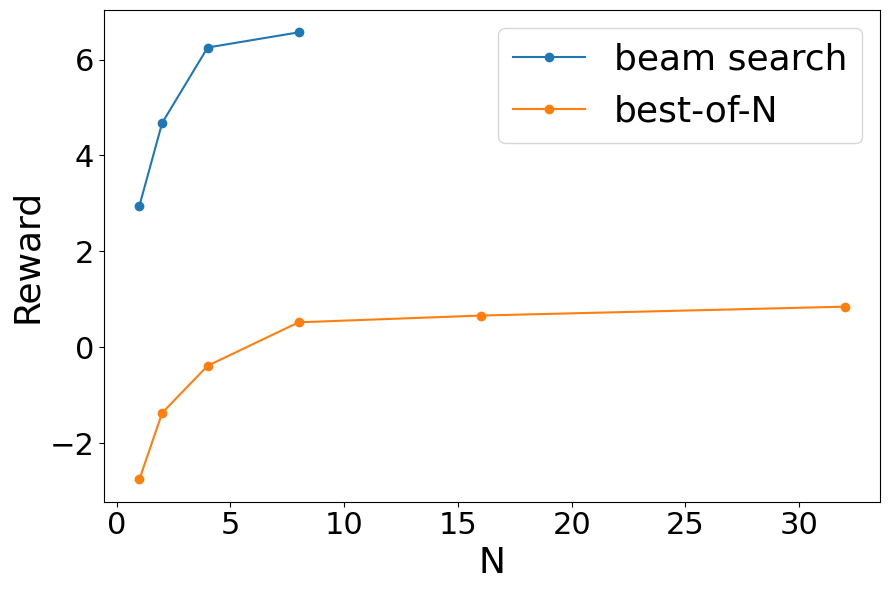

In [22]:
# accuracy over the entire dataset.
import matplotlib.pyplot as plt

avg_acc = beam_bon_chat_responses_only.groupby(["N", "method"])["eval_rm"].mean().reset_index()
plt.figure(figsize=(9,6))
for method, group in avg_acc.groupby("method"):
    group_sorted = group.sort_values("N")
    plt.plot(
        group_sorted["N"], 
        group_sorted["eval_rm"], 
        marker="o", 
        label=method
    )
plt.xlabel("N", fontsize=label_fontsize)
plt.ylabel("Reward", fontsize=label_fontsize)
# plt.title("Score by N, colored by method", fontsize=title_fontsize)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(labels=["beam search", "best-of-N"], title="", fontsize=label_fontsize, title_fontsize=label_fontsize)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2395635/283482777.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right", fontsize=22)
/tmp/ipykernel_2395635/283482777.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right", fontsize=22)


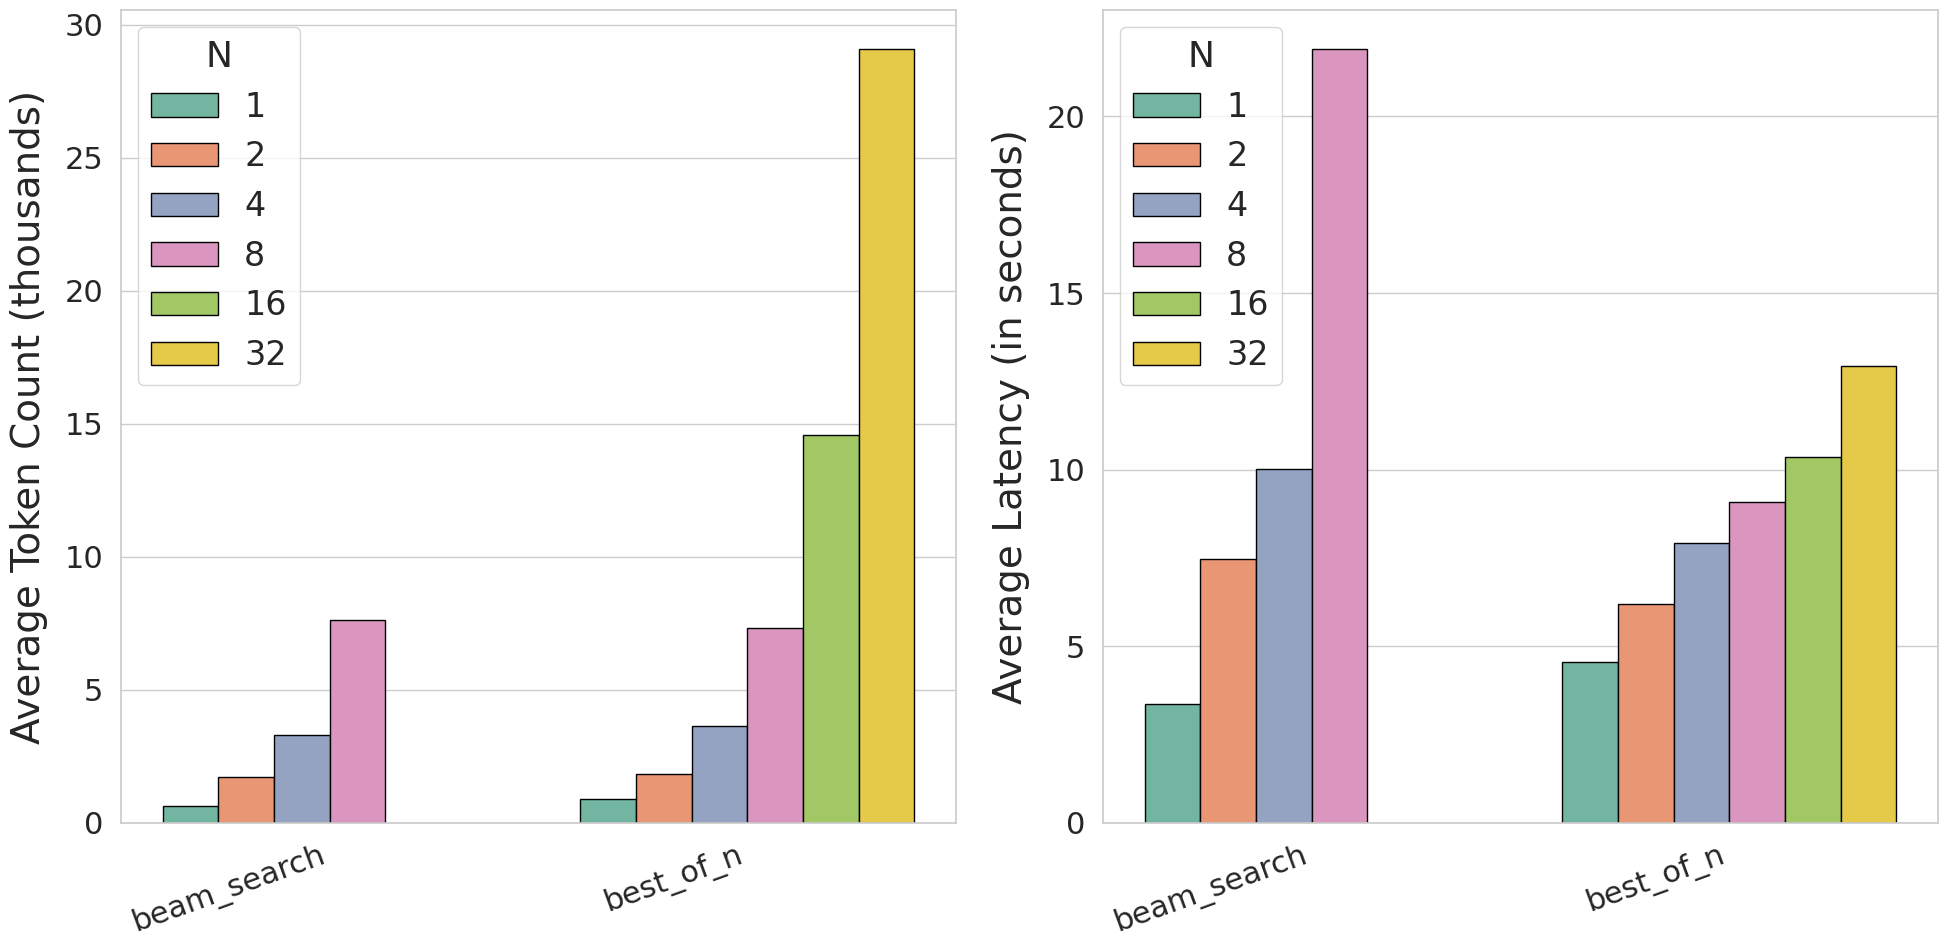

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Set even larger font sizes for all elements
sns.set(style="whitegrid", font_scale=2.0)  # Increase font_scale for larger fonts

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Larger figure for clarity

palette = sns.color_palette("Set2", n_colors=len(beam_bon_chat_responses_only["N"].unique()))

# token_count plot (in thousands)
df_token = beam_bon_chat_responses_only.groupby(["method", "N"])["token_count"].mean().reset_index()
df_token["token_count_k"] = df_token["token_count"] / 1000  # convert to thousands

# Convert N to int for legend (removes .0)
df_token["N_int"] = df_token["N"].astype(int)

sns.barplot(
    data=df_token,
    x="method",
    y="token_count_k",
    hue="N_int",
    ax=axs[0],
    palette=palette,
    edgecolor="black"
)
axs[0].set_ylabel("Average Token Count (thousands)", fontsize=28, labelpad=12)
axs[0].set_xlabel("", fontsize=28, labelpad=10)
# axs[0].set_title("Average token_count by Method and N", fontsize=30)
axs[0].legend(title="N", loc="upper left", frameon=True, fontsize=24, title_fontsize=26)

# Remove decimals from y-axis tick labels for token count
axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))

# time plot
df_time = beam_bon_chat_responses_only.groupby(["method", "N"])["time"].mean().reset_index()
df_time["N_int"] = df_time["N"].astype(int)

sns.barplot(
    data=df_time,
    x="method",
    y="time",
    hue="N_int",
    ax=axs[1],
    palette=palette,
    edgecolor="black"
)
axs[1].set_ylabel("Average Latency (in seconds)", fontsize=28, labelpad=12)
axs[1].set_xlabel("", fontsize=28, labelpad=10)
# axs[1].set_title("Average time by Method and N", fontsize=30)
axs[1].legend(title="N", loc="upper left", frameon=True, fontsize=24, title_fontsize=26)

# Remove decimals from y-axis tick labels for time plot
axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right", fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=22, width=2.5, length=9)
    ax.tick_params(axis='both', which='minor', labelsize=20, width=2, length=6)
    # Remove set_yticklabels to avoid UserWarning

plt.tight_layout()
plt.show()

# Probe Training

In [23]:
# create a train test split, and keep track of indices.
from sklearn.model_selection import train_test_split

# create train/test split based on unique prompts.
unique_prompts = beam_bon_chat_responses_only['prompt'].unique()

# Split sb_idx into train/test
sb_idx_train, sb_idx_test = train_test_split(
    unique_prompts,
    test_size=0.20, # .20
    random_state=1 # 6
)

# Divide queries into train and test sets.
df_train = beam_bon_chat_responses_only[beam_bon_chat_responses_only['prompt'].isin(sb_idx_train)].reset_index(drop=True)
df_test = beam_bon_chat_responses_only[beam_bon_chat_responses_only['prompt'].isin(sb_idx_test)].reset_index(drop=True)

In [24]:
df_train_renamed = df_train.rename(columns={"prompt": "question", "eval_rm": "sl"})
df_train_renamed.head() # columns now match the names in df_train_math.

df_test_renamed = df_test.rename(columns={"prompt": "question", "eval_rm": "sl"})
df_test_renamed.head() # columns now match the names in df_test_math.

,question,completions,best_completion,scores,token_count,time,sl,N,beam_width,max_iteration,method,method_beam,method_bon
0,"[""What's the best first move in tic-tac-toe?"",...",[The best first move in tic-tac-toe depends on...,The best first move in tic-tac-toe depends on ...,"[[0.933034718, 0.933034718]]",184,0.889693,2.703125,1,2,5,beam_search,1,0
1,"[""What is \""The Bloody Lip Bar and Grill\""?""]","[Unfortunately, I'm unable to provide details ...","Unfortunately, I'm unable to provide details a...","[[0.8751049042, 0.8751049042]]",129,0.712318,2.093750,1,2,5,beam_search,1,0
2,"[""could you tell a funny and whimsical story a...","[Sure, I can craft a fun and whimsical story f...","Sure, I can craft a fun and whimsical story fo...","[[0.5337949395, 0.5337949395]]",781,2.719791,-14.687500,1,2,5,beam_search,1,0
3,"[""I have frozen cod filets, tomatoes, lemons, ...",[Certainly! Here are some dinner ideas that yo...,Certainly! Here are some dinner ideas that you...,"[[0.6255370975, 0.6255370975]]",145,0.839499,-11.250000,1,2,5,beam_search,1,0
4,"[""The following is a command that the user is ...",[YES],YES,"[[0.8367722034, 0.8367722034]]",6,0.212820,11.062500,1,2,5,beam_search,1,0


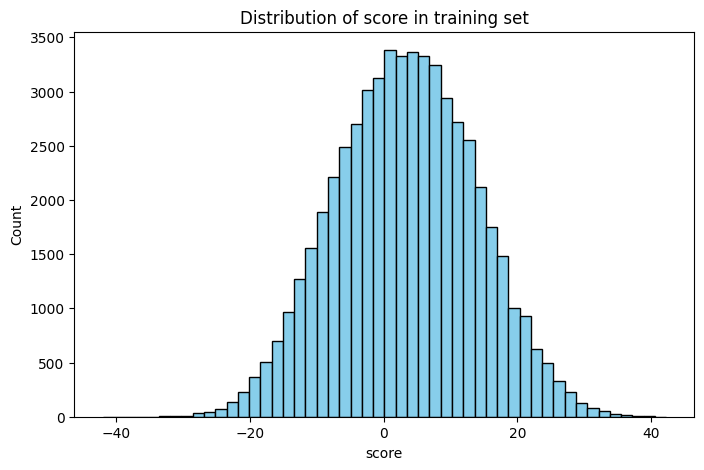

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_train['eval_rm'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('score')
plt.ylabel('Count')
plt.title('Distribution of score in training set')
plt.show()

In [9]:
sl = df_train['sl']
summary = sl.describe(percentiles=[0, 0.25, 0.5, 0.75, 1.0])
print("Five number summary:")
print(f"Min: {summary['min']}")
print(f"Q1: {summary['25%']}")
print(f"Median: {summary['50%']}")
print(f"Q3: {summary['75%']}")
print(f"Max: {summary['max']}")

percent_ones = (sl == 1).mean() * 100
print(f"Percent of values that are exactly 1: {percent_ones:.2f}%")

Five number summary:
Min: 2e-10
Q1: 0.9361391664
Median: 0.9990701675
Q3: 0.9999911785
Max: 1.0
Percent of values that are exactly 1: 8.07%


# Start Here for Router.

In [25]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

In [33]:
# df_train_renamed.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/sept-17/chat_train_df.csv", index=False)
# df_test_renamed.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/sept-17/chat_test_df.csv", index=False)
# read the csv files.
df_train = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/chat_train_df.csv")
df_test = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/chat_test_df.csv")

In [34]:
df_test['max_iteration'].unique()
df_test.shape

(22298, 13)

In [32]:
import numpy as np

x_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/test-features/X.npy"
x = np.load(x_path)
print(x.shape)

(22298, 1542)


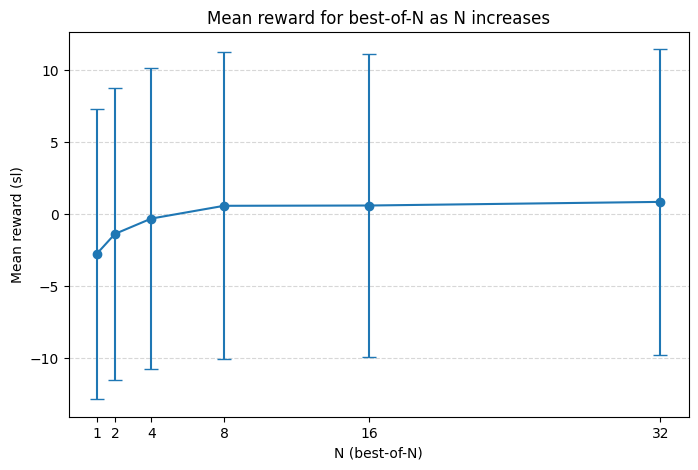

In [30]:
import matplotlib.pyplot as plt

# Get all unique N values for best_of_n, sorted
n_values = sorted(df_train[df_train['method'] == 'best_of_n']['N'].unique())

mean_rewards = []
std_rewards = []

for n in n_values:
    rewards = df_train[(df_train['N'] == n) & (df_train['method'] == 'best_of_n')]['sl']
    mean_rewards.append(rewards.mean())
    std_rewards.append(rewards.std())

plt.figure(figsize=(8, 5))
plt.errorbar(n_values, mean_rewards, yerr=std_rewards, fmt='-o', capsize=5)
plt.xlabel('N (best-of-N)')
plt.ylabel('Mean reward (sl)')
plt.title('Mean reward for best-of-N as N increases')
plt.xticks(n_values)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

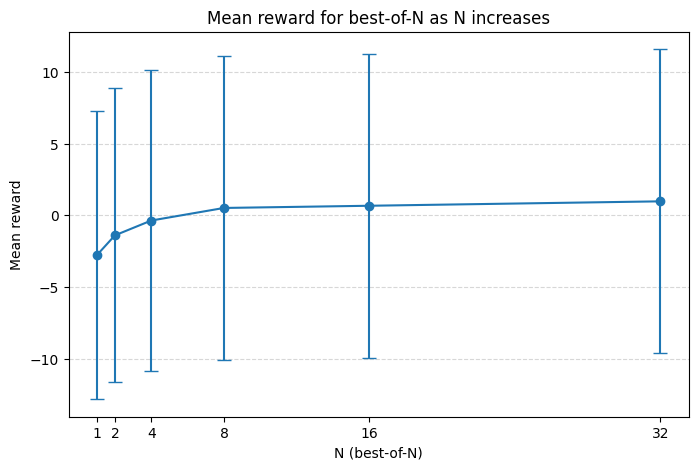

In [34]:
import matplotlib.pyplot as plt

# Get all unique N values for best_of_n, sorted
n_values = sorted(bo_all_rm_df[bo_all_rm_df['method'] == 'best_of_n']['N'].unique())

mean_rewards = []
std_rewards = []

for n in n_values:
    rewards = bo_all_rm_df[(bo_all_rm_df['N'] == n) & (bo_all_rm_df['method'] == 'best_of_n')]['eval_rm']
    mean_rewards.append(rewards.mean())
    std_rewards.append(rewards.std())

plt.figure(figsize=(8, 5))
plt.errorbar(n_values, mean_rewards, yerr=std_rewards, fmt='-o', capsize=5)
plt.xlabel('N (best-of-N)')
plt.ylabel('Mean reward')
plt.title('Mean reward for best-of-N as N increases')
plt.xticks(n_values)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

In [8]:
df_train[(df_train['N'] == 1) & (df_train['method'] == 'best_of_n')]['sl'].mean()

-2.774345931299499

In [9]:
best_of_n_out = df_train[df_train['method'] == 'best_of_n']

In [4]:
df_train.shape, df_test.shape # ((88852, 13), (22298, 13))

((55470, 14), (13940, 14))

# Create features for question type.

In [14]:
# Create indicator (one-hot) columns for each type present in df_test['type']
types = df_test['type'].unique()
for t in types:
    col_name = f"type_{t}"
    df_test[col_name] = (df_test['type'] == t).astype(int)

In [ ]:
types = df_train['type'].unique()
for t in types:
    col_name = f"type_{t}"
    df_train[col_name] = (df_train['type'] == t).astype(int)

In [4]:
# save the df_test and df_train with the one-hot encoded columns.
# df_test.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/sept-18/chat_test_class.csv", index=False)
# df_train.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/sept-18/chat_train_class.csv", index=False)

df_test = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/sept-18/chat_test_class.csv")
df_train = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/sept-18/chat_train_class.csv")

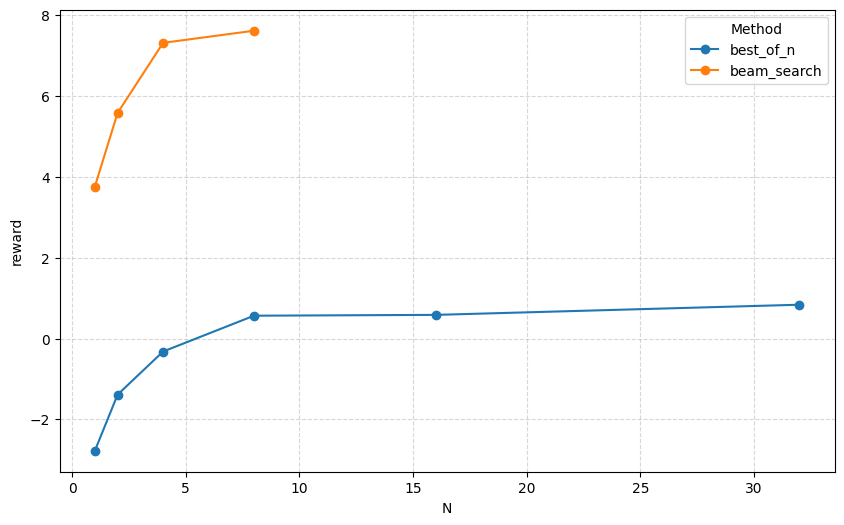

In [14]:
import matplotlib.pyplot as plt

# Filter for best_of_n and beam_search methods
methods_of_interest = ["best_of_n", "beam_search"]
df_plot = df_train[df_train["method"].isin(methods_of_interest)]

# Compute mean sl for each N and method
mean_sl = df_plot.groupby(["N", "method"])["sl"].mean().reset_index()

# Pivot for plotting
pivot = mean_sl.pivot(index="N", columns="method", values="sl")

plt.figure(figsize=(10, 6))
for method, color in zip(methods_of_interest, ["tab:blue", "tab:orange"]):
    if method in pivot.columns:
        plt.plot(pivot.index, pivot[method], marker='o', label=method, color=color)

plt.xlabel("N")
plt.ylabel("reward")
# plt.title("Mean sl vs N by Method")
plt.legend(title="Method")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### Cluster the problems using a clustering procedure.

create features.

In [36]:
import numpy as np

x_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/train-features/X.npy"
x = np.load(x_path)
print(x.shape)


(88852, 1542)


In [37]:
x[2000][-6:] # batch_beam_sizes, batch_beam_widths, batch_max_iterations, batch_problem_lengths, batch_method_beam, batch_method_bon

array([  1.,   2.,   5., 521.,   1.,   0.])

In [ ]:
# x_train = np.load("/dccstor/gma2/mehuldamani/search-and-learn/sept-18/train-features/X.npy")
# x_test = np.load("/dccstor/gma2/mehuldamani/search-and-learn/sept-18/test-features/X.npy")
# y_train = np.load("/dccstor/gma2/mehuldamani/search-and-learn/sept-18/train-features/y.npy")
# y_test = np.load("/dccstor/gma2/mehuldamani/search-and-learn/sept-18/test-features/y.npy")
# len(y_train),len(y_test)

(55470, 13940)

In [8]:
x_test.shape # type should be the last 7 columns.
x_test[0, -7:]

array([1., 0., 0., 0., 0., 0., 0.])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Compute first principal component of x[:, :-6]
pca = PCA(n_components=1)
x_pca1 = pca.fit_transform(x[:, :-6])

plt.figure(figsize=(6, 6))
plt.scatter(x_pca1, y_train, alpha=0.05, s=8)
plt.xlabel("Question Embedding (1st principal component)")
plt.ylabel("score")
plt.grid(True)
plt.show()

batch_type_writing_creative = type_writing_creative[i:i+batch_size]
batch_type_translation = type_translation[i:i+batch_size]
batch_type_other = type_other[i:i+batch_size]
batch_type_mathematics = type_mathematics[i:i+batch_size]
batch_type_general_knowledge = type_general_knowledge[i:i+batch_size]
batch_type_programming = type_programming[i:i+batch_size]
batch_type_advice_opinion = type_advice_opinion[i:i+batch_size]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

is_beam_search = x[:, -1]
unique_vals = np.unique(is_beam_search)
# Prepare data for each unique value of is_beam_search (should be 0 and 1)
data = [y_train[is_beam_search == val] for val in unique_vals]

plt.figure(figsize=(6, 6))
plt.boxplot(data, labels=[str(int(val)) for val in unique_vals], showfliers=True)
plt.xlabel("indicator")
plt.ylabel("score")
plt.title("Score by advice / opinion")
plt.grid(True, axis='y')
plt.show()

/tmp/ipykernel_3307928/1817962056.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(int(val)) for val in unique_vals], showfliers=True)


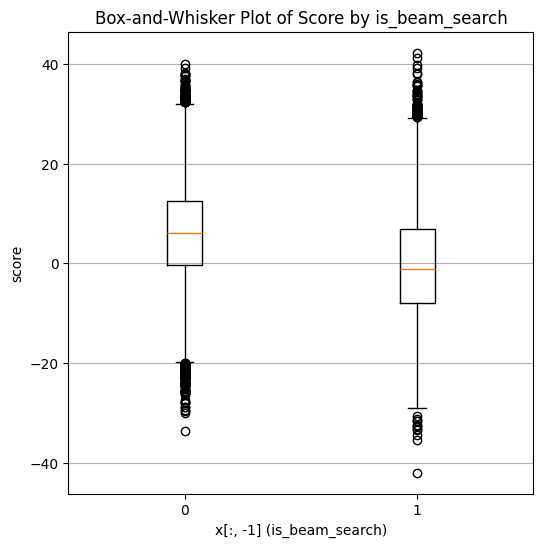

In [13]:
import matplotlib.pyplot as plt
import numpy as np

is_beam_search = x[:, -1]
unique_vals = np.unique(is_beam_search)
# Prepare data for each unique value of is_beam_search (should be 0 and 1)
data = [y_train[is_beam_search == val] for val in unique_vals]

plt.figure(figsize=(6, 6))
plt.boxplot(data, labels=[str(int(val)) for val in unique_vals], showfliers=True)
plt.xlabel("x[:, -1] (is_beam_search)")
plt.ylabel("score")
plt.title("Box-and-Whisker Plot of Score by is_beam_search")
plt.grid(True, axis='y')
plt.show()

Train the Router.

In [20]:
# load in completed predicted probabilities.
ys = np.load("/dccstor/gma2/mehuldamani/search-and-learn/sept-18/test-features/y.npy")
calibrated_probs = np.load("/dccstor/gma2/mehuldamani/search-and-learn/sept-18/model/model_scores_calibrated.npy")

print(calibrated_probs.shape, calibrated_probs.min().item(), calibrated_probs.max().item())
print(ys.shape, ys.min().item(), ys.max().item())

ys.shape, calibrated_probs.shape

(13940,) -71.70915222167969 21.98821258544922
(13940,) -32.5 41.0


((13940,), (13940,))

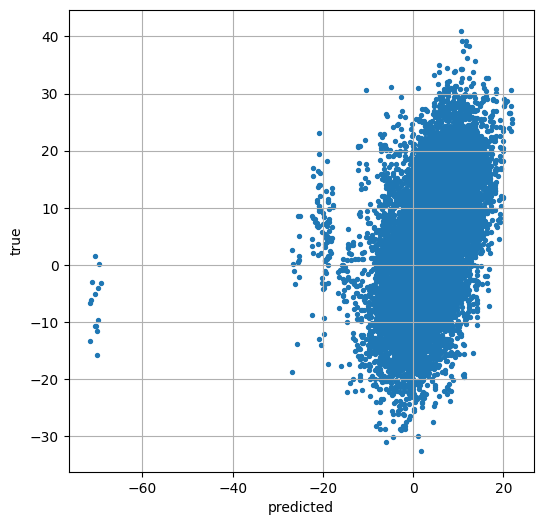

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(calibrated_probs, ys, alpha=1, s=8)
plt.ylabel("true")
plt.xlabel("predicted")
# plt.title("Scatter plot of ys vs calibrated_probs (5000 Questions)")
plt.grid(True)
plt.show()

In [22]:
df_test['calibrated_probs'] = calibrated_probs

# Routing Results.

In [ ]:
# Create new columns for predicted token count and time based on group means
group_means = df_train.groupby(["method", "N", "beam_width", "max_iteration"])[["token_count", "time"]].mean().reset_index()
# group_means = df_train[["token_count", "time"]].mean().to_frame().T
group_means = group_means.rename(columns={"token_count": "token_count_pred", "time": "time_pred"})
group_means.head()
# Merge these means back into df_test
df_test = df_test.merge(group_means, on=["method", "N", "beam_width", "max_iteration"], how="left")

In [21]:
df_test.shape

(13940, 16)

In [25]:
# get the average accuracy and token_count for each configuration.
config_summary_df = df_test.groupby(["N", "beam_width", "max_iteration", "method"])[
    ["token_count", "time", "sl", "calibrated_probs", "token_count_pred", "time_pred"]
].mean().reset_index()

In [26]:
config_summary_df.head()

,N,beam_width,max_iteration,method,token_count,time,sl,calibrated_probs,token_count_pred,time_pred
0,1,1,40,best_of_n,905.036853,4.541804,-2.671707,1.606595,910.067903,4.564926
1,1,2,40,beam_search,606.070929,4.786536,3.669201,4.038444,588.547302,4.489466
2,1,4,40,beam_search,1178.473000,5.127620,3.819040,5.102363,1164.788669,4.903788
3,2,1,40,best_of_n,1834.972797,6.259061,-1.287711,1.582580,1820.371288,6.198698
4,2,2,40,beam_search,1301.977000,8.790645,6.327958,4.048558,1262.972858,8.139092


In [27]:
df_test['question'].nunique() # 983 unique questions in the test set.

983

In [28]:
def compute_max_utility_pred(df, lambda_, method="oracle", cost="token_count_pred"):
    def get_max_utility(group):
        group = group.copy()
        if method == "oracle":
            group["utility"] = group["sl"] - lambda_ * group[cost]
        elif method == "adaptive_router":
            group["utility"] = group["calibrated_probs"] - lambda_ * group[cost]
            # print("the sl for this question is", group["sl"].iloc[0])
            # print("the cost for this question is", group[cost].iloc[0])
        else:
            raise ValueError(f"Invalid method: {method}")
        idx_max = group["utility"].idxmax()

        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "calibrated_probs"],
            "max_eval_rm": group.loc[idx_max, "sl"],
            "max_cost": group.loc[idx_max, "token_count"],
            "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"]
        })

    result_df = df.groupby("question").apply(get_max_utility).reset_index()
    return result_df # your code.

In [29]:
# route for a list of lambdas.
def get_router_df(input_df, lambda_list, method="oracle", cost="token_count"):
    results = []

    for lambda_value in lambda_list:
        adaptive_router = compute_max_utility_pred(input_df, lambda_value, method, cost)
        average_accuracy = adaptive_router["max_eval_rm"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
        average_cost = adaptive_router["max_cost"].mean() # average over all questions in test set for adaptive router.
        average_time = adaptive_router["max_time"].mean()
        average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
        
        results.append({
            "lambda": lambda_value,
            "eval_rm": average_accuracy,
            "predicted_prob": average_predicted_prob,
            "token_count": average_cost,
            "time": average_time,
        })

    # Convert to DataFrame
    output_df = pd.DataFrame(results)
    output_df["method"] = method

    return output_df

In [30]:
oracle_tc = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=50), method="oracle", cost="token_count")
adaptive_tc = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=50), method="adaptive_router", cost="token_count_pred")
adaptive_oracle_tc = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=50), method="adaptive_router", cost="token_count")

adaptive_oracle_lat = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=50), method="adaptive_router", cost="time")
adaptive_lat = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=50), method="adaptive_router", cost="time_pred")
oracle_lat = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=50), method="oracle", cost="time")

/tmp/ipykernel_3085120/1051258036.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("question").apply(get_max_utility).reset_index()
/tmp/ipykernel_3085120/1051258036.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("question").apply(get_max_utility).reset_index()
/tmp/ipykernel_3085120/1051258036.py:23: FutureWarning: DataFrameGroupBy.apply operated on the groupin

/tmp/ipykernel_3085120/1051258036.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("question").apply(get_max_utility).reset_index()
/tmp/ipykernel_3085120/1051258036.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("question").apply(get_max_utility).reset_index()
/tmp/ipykernel_3085120/1051258036.py:23: FutureWarning: DataFrameGroupBy.apply operated on the groupin

In [31]:
adaptive_tc.head()

,lambda,eval_rm,predicted_prob,token_count,time,method
0,1.000000e-07,5.929917,5.114216,7471.438454,29.583191,adaptive_router
1,1.325711e-07,5.929917,5.114216,7471.438454,29.583191,adaptive_router
2,1.757511e-07,5.929917,5.114216,7471.438454,29.583191,adaptive_router
3,2.329952e-07,5.900797,5.114214,7466.624619,29.567103,adaptive_router
4,3.088844e-07,5.864715,5.114204,7430.928789,29.458040,adaptive_router


In [32]:
adaptive_lat.head()

,lambda,eval_rm,predicted_prob,token_count,time,method
0,0.000010,5.933351,5.114217,7476.101729,29.591757,adaptive_router
1,0.000012,5.933351,5.114217,7476.101729,29.591757,adaptive_router
2,0.000015,5.933351,5.114217,7476.101729,29.591757,adaptive_router
3,0.000018,5.933351,5.114217,7476.101729,29.591757,adaptive_router
4,0.000021,5.933351,5.114217,7476.101729,29.591757,adaptive_router


In [33]:
adaptive_lat.head()

,lambda,eval_rm,predicted_prob,token_count,time,method
0,0.000010,5.933351,5.114217,7476.101729,29.591757,adaptive_router
1,0.000012,5.933351,5.114217,7476.101729,29.591757,adaptive_router
2,0.000015,5.933351,5.114217,7476.101729,29.591757,adaptive_router
3,0.000018,5.933351,5.114217,7476.101729,29.591757,adaptive_router
4,0.000021,5.933351,5.114217,7476.101729,29.591757,adaptive_router


In [34]:
oracle_tc.head()

,lambda,eval_rm,predicted_prob,token_count,time,method
0,1.000000e-07,14.280136,3.833284,7664.233978,24.923025,oracle
1,1.325711e-07,14.280136,3.833284,7664.233978,24.923025,oracle
2,1.757511e-07,14.280136,3.833284,7664.233978,24.923025,oracle
3,2.329952e-07,14.280136,3.833284,7664.233978,24.923025,oracle
4,3.088844e-07,14.280136,3.833284,7664.233978,24.923025,oracle


In [35]:
oracle_lat.head()

,lambda,eval_rm,predicted_prob,token_count,time,method
0,0.000010,14.280136,3.834106,7679.333672,24.816595,oracle
1,0.000012,14.280136,3.834106,7679.333672,24.816595,oracle
2,0.000015,14.280136,3.834106,7679.333672,24.816595,oracle
3,0.000018,14.280136,3.834106,7679.333672,24.816595,oracle
4,0.000021,14.280136,3.834106,7679.333672,24.816595,oracle


Fill in "-1"'s for the configuration-related columns for the router + oracle.

In [36]:
adaptive_oracle_tc['N'] = -1
adaptive_oracle_lat['N'] = -1
adaptive_tc['N'] = -1
adaptive_lat['N'] = -1
oracle_tc['N'] = -1
oracle_lat['N'] = -1

In [37]:
config_summary_df.rename(columns={"calibrated_probs": "predicted_prob"}, inplace=True)
config_summary_df.rename(columns={"sl": "eval_rm"}, inplace=True)

In [38]:
adaptive_oracle_tc['method'] = 'oracle_cost'
adaptive_oracle_lat['method'] = 'oracle_cost'

In [39]:
config_summary_df.head()

,N,beam_width,max_iteration,method,token_count,time,eval_rm,predicted_prob,token_count_pred,time_pred
0,1,1,40,best_of_n,905.036853,4.541804,-2.671707,1.606595,910.067903,4.564926
1,1,2,40,beam_search,606.070929,4.786536,3.669201,4.038444,588.547302,4.489466
2,1,4,40,beam_search,1178.473000,5.127620,3.819040,5.102363,1164.788669,4.903788
3,2,1,40,best_of_n,1834.972797,6.259061,-1.287711,1.582580,1820.371288,6.198698
4,2,2,40,beam_search,1301.977000,8.790645,6.327958,4.048558,1262.972858,8.139092


In [40]:
# outer join on the shared columns
df_1_tc = pd.merge(
    adaptive_tc,
    config_summary_df,
    on=["eval_rm", "token_count", "time", "predicted_prob", "N", "method"],
    how="outer"
)
df_2_tc = pd.merge(
    df_1_tc,
    oracle_tc,
    on=["lambda", "eval_rm", "token_count", "time", "predicted_prob", "N", "method"],
    how="outer"
)
df_3_tc = pd.merge(
    df_2_tc,
    adaptive_oracle_tc,
    on=["lambda", "eval_rm", "token_count", "time", "predicted_prob", "N", "method"],
    how="outer"
)
# Replace NaN values with -1 for plotting purposes
query_optimal_tc = df_3_tc.fillna(-1)

In [41]:
query_optimal_tc['method'].unique()

array(['adaptive_router', 'oracle_cost', 'oracle', 'best_of_n',
       'beam_search'], dtype=object)

In [42]:
# outer join on the shared columns
df_1_lat = pd.merge(
    adaptive_lat,
    config_summary_df,
    on=["eval_rm", "token_count", "time", "predicted_prob", "N", "method"],
    how="outer"
)
df_2_lat = pd.merge(
    df_1_lat,
    oracle_lat,
    on=["lambda", "eval_rm", "token_count", "time", "predicted_prob", "N", "method"],
    how="outer"
)
df_3_lat = pd.merge(
    df_2_lat,
    adaptive_oracle_lat,
    on=["lambda", "eval_rm", "token_count", "time", "predicted_prob", "N", "method"],
    how="outer"
)
# Replace NaN values with -1 for plotting purposes
query_optimal_lat = df_3_lat.fillna(-1)

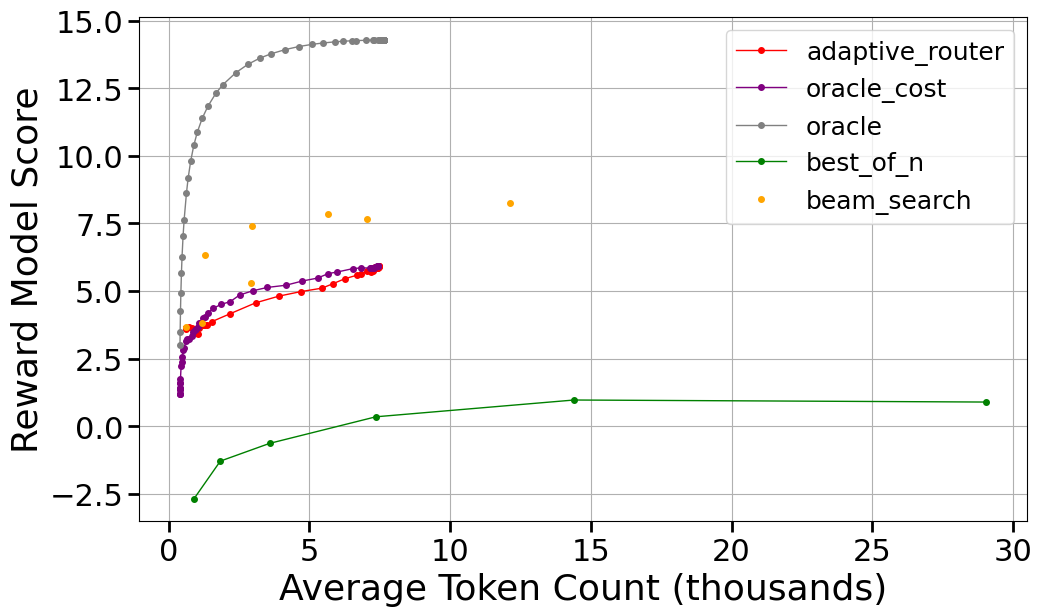

In [43]:
# router on token count.
method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "best_of_n": "green",
    "beam_search": "orange",
}

plt.figure(figsize=(10, 6))

for method in query_optimal_tc["method"].unique():
    method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
    color = method_colors.get(method, "adaptive")
    if method == "beam_search":
        plt.plot(
            method_df["token_count"] / 1000, 
            method_df["eval_rm"], 
            marker="o", 
            linestyle="None", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )
    else:
        plt.plot(
            method_df["token_count"] / 1000, 
            method_df["eval_rm"], 
            marker="o", 
            linestyle="-", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )

plt.xlabel("Average Token Count (thousands)", fontsize=26)
plt.ylabel("Reward Model Score", fontsize=26)
plt.legend(title="", fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)
plt.show()

In [44]:
df_test.head()

,question,completions,best_completion,scores,token_count,time,sl,N,beam_width,max_iteration,...,type_Writing-Creative,type_Translation,type_Other,type_Mathematics,type_General Knowledge,type_Programming,type_Advice-Opinion,calibrated_probs,token_count_pred,time_pred
0,"[""Construct a rap battle, in the style of Epic...","['**(Verse 1 of Zeus)**\n**Zeus**: ""I rule the...","**(Verse 1 of Zeus)**\n**Zeus**: ""I rule the s...","[[0.8599925637, 0.5857453346, 0.70378726720000...",1042,7.172534,-3.843750,1,2,40,...,1,0,0,0,0,0,0,-1.086472,588.547302,4.489466
1,"[""was the historical jesus a socialist"",""was h...",['I\'ll address each of your questions one by ...,I'll address each of your questions one by one...,"[[0.941537559, 0.8765249252, 0.160448238300000...",1070,5.864859,-4.062500,1,2,40,...,0,1,0,0,0,0,0,1.518486,588.547302,4.489466
2,"[""What's the best first move in tic-tac-toe?"",...","['The best ""first move"" in tic-tac-toe is to a...","The best ""first move"" in tic-tac-toe is to alw...","[[0.8800978065, 0.8800978065]]",133,0.872696,0.820312,1,2,40,...,0,0,1,0,0,0,0,1.946285,588.547302,4.489466
3,"[""how to delete kcptun on server?""]","[""To delete a KCMTUN (KVM Network Tuner) clien...",To delete a KCMTUN (KVM Network Tuner) client ...,"[[0.8973057270000001, 0.77951473, 0.8839787841...",622,3.626210,-7.625000,1,2,40,...,0,0,1,0,0,0,0,3.241749,588.547302,4.489466
4,"[""What is the scientific probability of earth ...","[""The question of whether Earth is the only ha...",The question of whether Earth is the only habi...,"[[0.7755689621, 0.7755689621]]",569,3.214363,-0.369141,1,2,40,...,0,0,0,1,0,0,0,4.592106,588.547302,4.489466


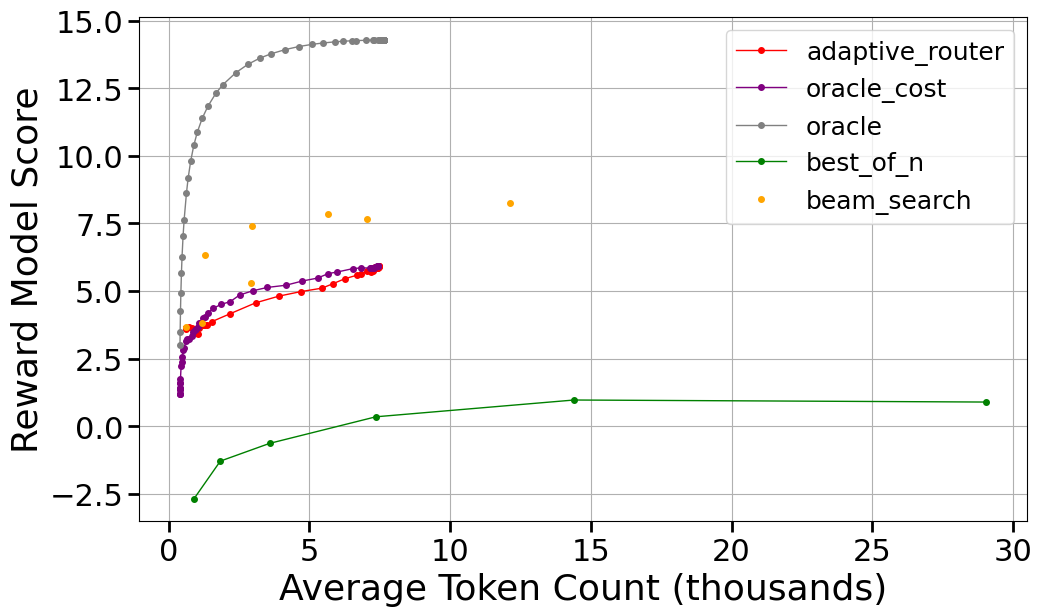

In [45]:
# router on token count.
method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "best_of_n": "green",
    "beam_search": "orange",
}

plt.figure(figsize=(10, 6))

for method in query_optimal_tc["method"].unique():
    method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
    color = method_colors.get(method, "adaptive")
    if method == "beam_search":
        plt.plot(
            method_df["token_count"] / 1000, 
            method_df["eval_rm"], 
            marker="o", 
            linestyle="None", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )
    else:
        plt.plot(
            method_df["token_count"] / 1000, 
            method_df["eval_rm"], 
            marker="o", 
            linestyle="-", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )

plt.xlabel("Average Token Count (thousands)", fontsize=26)
plt.ylabel("Reward Model Score", fontsize=26)
plt.legend(title="", fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)
plt.show()

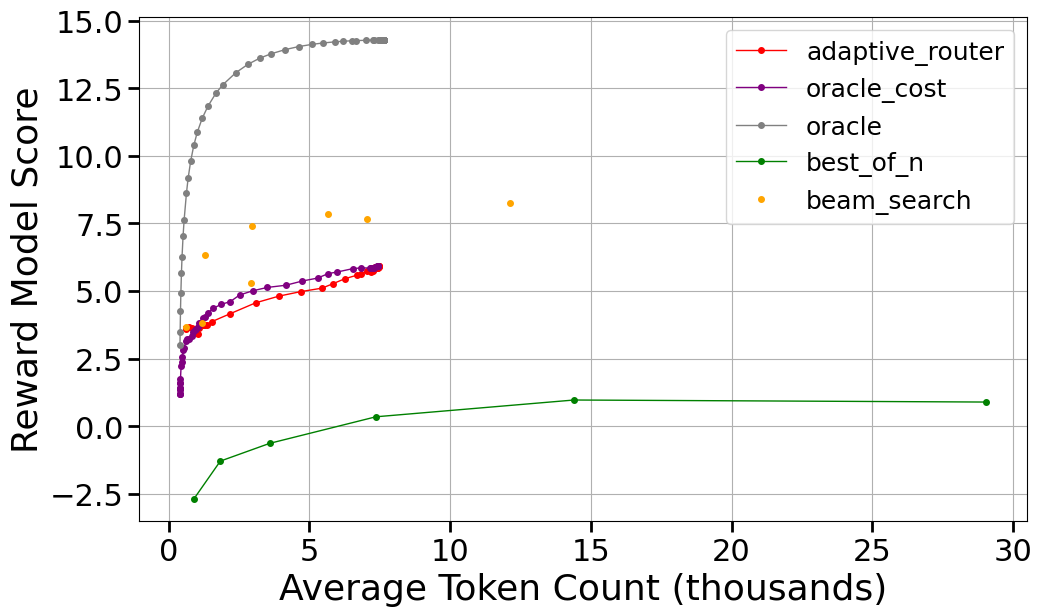

In [46]:
# router on token count.
method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "best_of_n": "green",
    "beam_search": "orange",
}

plt.figure(figsize=(10, 6))

for method in query_optimal_tc["method"].unique():
    method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
    color = method_colors.get(method, "adaptive")
    if method == "beam_search":
        plt.plot(
            method_df["token_count"] / 1000, 
            method_df["eval_rm"], 
            marker="o", 
            linestyle="None", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )
    else:
        plt.plot(
            method_df["token_count"] / 1000, 
            method_df["eval_rm"], 
            marker="o", 
            linestyle="-", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )

plt.xlabel("Average Token Count (thousands)", fontsize=26)
plt.ylabel("Reward Model Score", fontsize=26)
plt.legend(title="", fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)
plt.show() # check same reward model used.

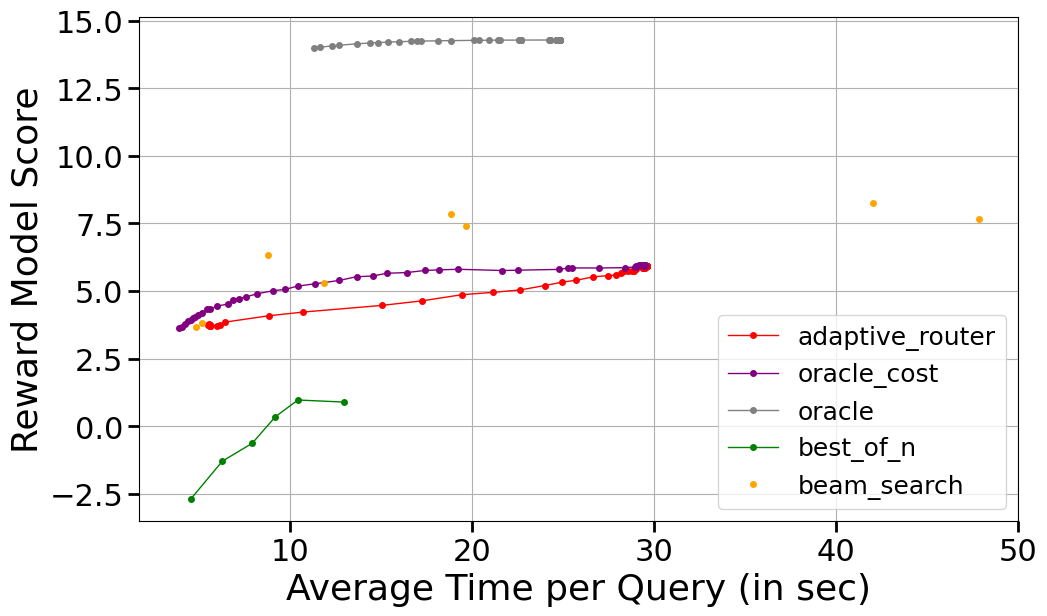

In [47]:
# router on time.
method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "best_of_n": "green",
    "beam_search": "orange",
}

plt.figure(figsize=(10, 6))

for method in query_optimal_lat["method"].unique():
    method_df = query_optimal_lat[query_optimal_lat["method"] == method].sort_values("time")
    color = method_colors.get(method, "adaptive")
    if method == "beam_search":
        plt.plot(
            method_df["time"], 
            method_df["eval_rm"], 
            marker="o", 
            linestyle="None", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )
    else:
        plt.plot(
            method_df["time"], 
            method_df["eval_rm"], 
            marker="o", 
            linestyle="-", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )

plt.xlabel("Average Time per Query (in sec)", fontsize=26)
plt.ylabel("Reward Model Score", fontsize=26)
plt.legend(title="", fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)
plt.show()

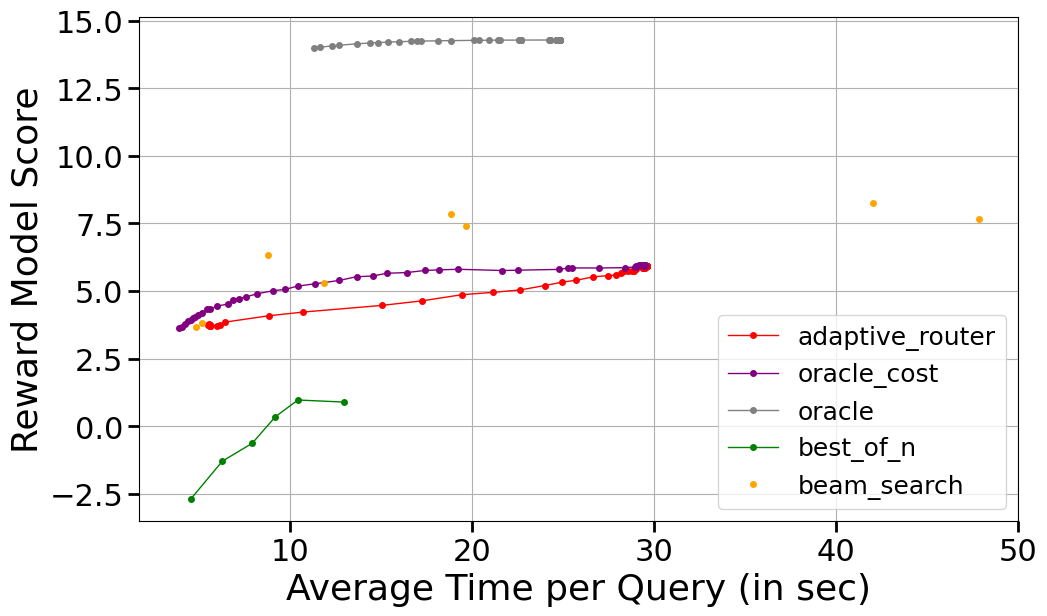

In [48]:
# router on token count.
method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "best_of_n": "green",
    "beam_search": "orange",
}

plt.figure(figsize=(10, 6))

for method in query_optimal_lat["method"].unique():
    method_df = query_optimal_lat[query_optimal_lat["method"] == method].sort_values("time")
    color = method_colors.get(method, "adaptive")
    if method == "beam_search":
        plt.plot(
            method_df["time"], 
            method_df["eval_rm"], 
            marker="o", 
            linestyle="None", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )
    else:
        plt.plot(
            method_df["time"], 
            method_df["eval_rm"], 
            marker="o", 
            linestyle="-", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )

plt.xlabel("Average Time per Query (in sec)", fontsize=26)
plt.ylabel("Reward Model Score", fontsize=26)
plt.legend(title="", fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)
plt.show()